## Overfitting

Measuring the performance on the same dataset on which a model is fitted can be misleading, especially in the presence of noise. Most models can learn the training instances very well, leading to a training performance that will be very high, but may fail to generalise, so the "true" performance, when trying to predict a new dataset, will be significantly lower. This phenomenon is called _overfitting_.

For instance, on this dataset:


In [1]:
import pandas as pd
d = pd.DataFrame({'X': [1, 2, 3, 4, 6, 7, 8, 8.5, 9, 10],
                  'Y': [0, 0, 0, 0, 1, 1, 1, 0, 1, 1]})
d

,X,Y
0,1.0,0
1,2.0,0
2,3.0,0
3,4.0,0
4,6.0,1
5,7.0,1
6,8.0,1
7,8.5,0
8,9.0,1
9,10.0,1


the training performance for a decision tree is:

In [2]:
from sklearn import tree
X = d[['X']]
y = d['Y']
dt = tree.DecisionTreeClassifier(criterion='entropy').fit(X,y)
dt.score(X, y)

1.0

So it can correctly predict every instance seen in the training dataset.

But what if $X=9$ and $X=1$ were not available in the training dataset, what would be the accuracy on the original dataset (that does include them)?

In [3]:
d1 = d.drop([1, 8])
X1 = d1[['X']]
y1 = d1['Y']
dt = tree.DecisionTreeClassifier(criterion='entropy').fit(X1,y1)
dt.score(X, y)

0.9

So one of the points was still predicted correctly, but one was not, even if the training accuracy is 100%. 

_Overfitting_ is particularly important for algorithms like decision trees, which will always have perfect accuracy on a consistent dataset, but that doesn't mean that they will predict 100% accurately any new data points.

## Testing accuracy

One way to counter this measurement problem is to train on only a part of the dataset and measure performance on the remaining portion, called a _test set_. Common ratios between the training set and the test set are 3:1 or 4:1.

We can do this in Python using the `train_test_split()` function:

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
dt = tree.DecisionTreeClassifier(criterion='entropy').fit(X_train,y_train)
print("Training accuracy:", dt.score(X_train, y_train))
print("Testing accuracy:", dt.score(X_test, y_test))

Training accuracy: 1.0
Testing accuracy: 0.6666666666666666


Training accuracy is still 100%, while testing accuracy is significantly lower, but it does gives a better indication on how this model performs on unseen data.

---
**Give it a try!**

For the iris dataset, calculate the training and testing accuracies using `train_test_split()` with parameters:

* `test_size=0.3` and `random_state=0`;
* `test_size=0.3` and `random_state=1`.

In [5]:
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np

iris = load_iris()
d1 = pd.DataFrame(
    data = np.c_[iris['data'], pd.Categorical.from_codes(iris.target, iris.target_names)],
    columns= iris['feature_names'] + ['class'])

dt = tree.DecisionTreeClassifier(criterion='entropy', random_state=1)
# Your code here

Expected results:

* for `random_state=0`: training acc: 1, testing acc: 0.9777777777777777
* for `random_state=1`: training acc: 1, testing acc: 0.9555555555555556

---

## Cross-validation

However, by partitioning the available data into multiple sets, we drastically reduce the number of samples which can be used for learning the model, and the results can depend on a particular random choice for the pair of (train, validation) sets.

An even more advanced strategy is to repeat the entire procedure multiple times and, in turn, use each part of the dataset as the test set. This is called _cross validation_ (_CV_).

* Partition the available data D into k disjoint subsets of equal size
* Remove, in turn, each subset from D and train the algorithm on the remaining instances
* Apply the trained algorithm on the saved subset and count the errors
* The total error for cross-validation is the sum of errors at each step

![Cross Validation](img/cross_validation.png)

Using `cross_val_predict()` or just `cross_val_score()` we can get the accuracy score for each of the 5 splits, which we can then average for a final CV mean score:

In [6]:
from sklearn.model_selection import cross_val_score
from statistics import mean
classifier = tree.DecisionTreeClassifier(criterion='entropy')
scores = cross_val_score(classifier, X, y, cv=5)
print("CV scores:", scores)
print("Mean CV score: ", mean(scores))

CV scores: [1.  1.  0.5 0.5 0.5]
Mean CV score:  0.7


A variation of this is to use very many folds, up to just using one fold for each instance, which is usually called _CV leave-one-out_ (_CVLOO_).

This is available as `LeaveOneOut()`, while a more general `LeavePOut()` function is also available, so we can do a CVLOO with:

In [7]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
scores = cross_val_score(classifier, X, y, cv=loo)
print("CVLOO scores:", scores)
print("Mean CVLOO score: ", mean(scores))

CVLOO scores: [1. 1. 1. 1. 1. 1. 0. 0. 0. 1.]
Mean CVLOO score:  0.7


Average accuracy for CLOO and 5-fold CV are usually close and using one over the other depends on the size of the dataset, since CVLOO running time scales with the size of the dataset, while 5-fold CV always does exactly 5 train-predict runs.

For more details see https://scikit-learn.org/stable/modules/cross_validation.html

---
**Give it a try!**

For the iris dataset, calculate the cross-validation accuracy using `cross_val_score()` with:

* `cv=KFold(n_splits=5, shuffle=True, random_state=0)` 
* `cv=KFold(n_splits=5, shuffle=True, random_state=1)`

In [8]:
from sklearn.datasets import load_iris
from sklearn.model_selection import KFold

iris = load_iris()
d1 = pd.DataFrame(
    data = np.c_[iris['data'], pd.Categorical.from_codes(iris.target, iris.target_names)],
    columns= iris['feature_names'] + ['class'])

classifier = tree.DecisionTreeClassifier(criterion='entropy', random_state=3)
# Your code here

Expected results:

* for `random_state=0`, accuracy: 0.9533333333333334
* for `random_state=1`, accuracy: 0.9400000000000001

---

## Pruning decision trees

Since cross-validation provides a better measurement in the context of overfitting, the models themselves could be improved by focusing on increasing the cross-validation performance instead of the training performance.

For decision trees, a common technique is to actually reduce the size of the learned tree, which allows the models to generalise better. This effectively trades training performance for CV performance.

Let's look again at the example above. The full learned tree is this:

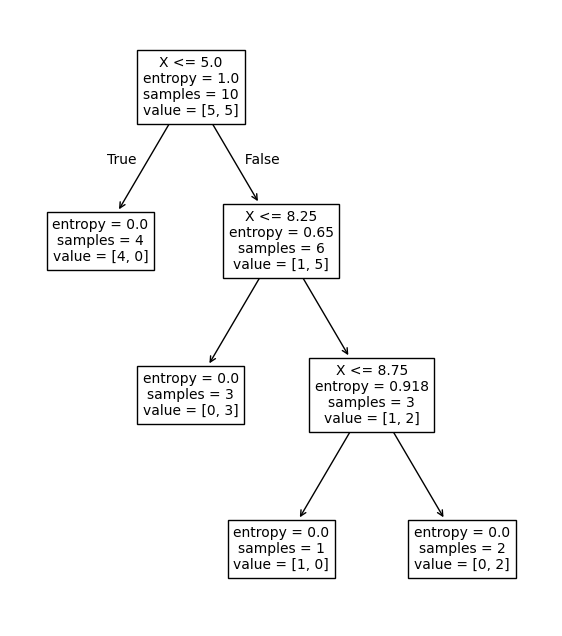

Training accuracy: 1.0
Mean CVLOO accuracy:  0.7


In [9]:
import matplotlib.pyplot as plt
X = d[['X']]
y = d['Y']
classifier = tree.DecisionTreeClassifier(criterion='entropy')
# Fit and score on the entire dataset
dt = classifier.fit(X, y)
fig, ax = plt.subplots(figsize=(7, 8))
f = tree.plot_tree(dt, ax=ax, fontsize=10, feature_names=X.columns)
plt.show()
print("Training accuracy:", dt.score(X, y))
# Fit multiple times and average the scores from the 10 CVLOO runs
loo = LeaveOneOut()
print("Mean CVLOO accuracy: ", mean(cross_val_score(classifier, X, y, cv=loo)))

We can try to stop the tree from growing once it reaches a certain depth using the `max_depth` parameter:

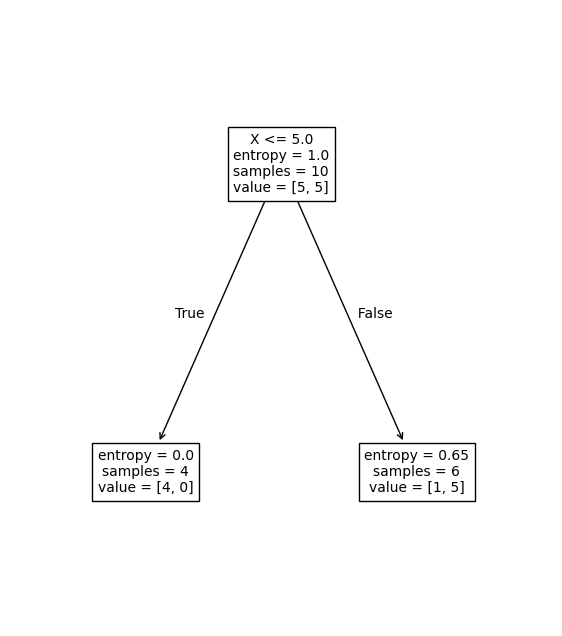

Training accuracy: 0.9
Mean CVLOO accuracy:  0.9


In [10]:
classifier = tree.DecisionTreeClassifier(criterion='entropy', max_depth=1).fit(X,y)
# Fit and score on the entire dataset
dt = classifier.fit(X, y)
fig, ax = plt.subplots(figsize=(7, 8))
f = tree.plot_tree(dt, ax=ax, fontsize=10, feature_names=X.columns)
plt.show()
print("Training accuracy:", dt.score(X, y))
# Fit multiple times and average the scores from the 10 CVLOO runs
loo = LeaveOneOut()
print("Mean CVLOO accuracy: ", mean(cross_val_score(classifier, X, y, cv=loo)))

We can see how the CVLOO accuracy has increased as the trees are now much simpler and the training accuracy has decreased slightly, to match the CVLOO accuracy.

The correct value of `max_depth` in each case should be determined by simply trying different values in what is called _parameter tuning_ or the _metaoptimisation_ phase of a ML algorithm.

## Decision surface

To get an intuitive feel for how the ID3 classifier works, we could use a 2D dataset with only 2 output classes:

In [11]:
import pandas as pd
d = pd.DataFrame({
    'X1': [-1, 0, 0, 1, 1, 1, 2, 2],
    'X2': [1, 1, 2, -1, 0, 2, 2, 3],
    'y': [0, 1, 0, 0, 1, 1, 0, 1]
})
X, y = d[['X1', 'X2']], d['y']

which we can plot using [`matplotlib`](https://matplotlib.org/):

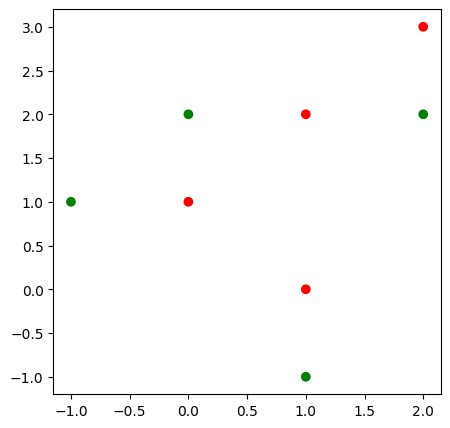

In [12]:
import matplotlib.pyplot as plt
c= ['green' if l == 0 else 'red' for l in y]
fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(X['X1'], X['X2'], color=c)
plt.show()

where green represents class '0' and red represents class '1'.

If we then train a decision tree classifier on this dataset, we can visualise the decision surface with:

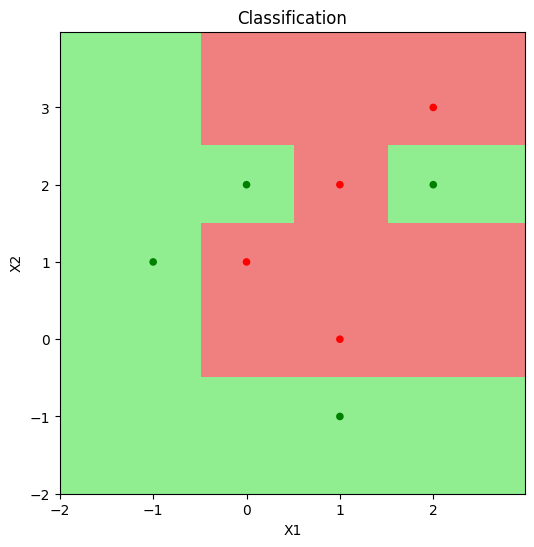

In [13]:
from tools.plots import plot_decision_surface

classifier = tree.DecisionTreeClassifier(criterion='entropy').fit(X, y)
plot_decision_surface(classifier, X, y)

The green area represents all instances which this decision tree would classify as '0' and likewise any point in the red area will be classified as '1'.

Note how the edge of the decision surface is always parallel to the axes. This is because decision trees can only learn binary splits at different points along the input variables; they cannot learn linear functions (such as a diagonal line). On the lower left side for example, a diagonal line would better separate the two outer green points, but the decision tree approximates that using a vertical and a horizontal line.

Even with this limitation they can perform very well in practice because a sufficiently deep tree can approximate any curved line with enough precision.

# Naive Bayes

Bayesian classifiers and in particular the naive Bayes classifier are a family of probabilistic classification algorithms particularly suited to problems like text classification.

When to use it:

* The target function $f$ takes value from a finite set $V=\{v_1,...,v_k\}$
* Moderate or large training data set is available
* The attributes $<a_1,...,a_n>$ that describes instances are conditionally independent with respect to the given classification:

$$P(a_1,a_2,...,a_n|v_j)=\prod_i P(a_i|v_j)$$

The most probable value of $f(x)$ is:

\begin{align}
v_{MAP} &= \mbox{argmax}_{v_j \in V}P(v_j|a_1,a_2,...,a_n) \\
      &= \mbox{argmax}_{v_j \in V}\frac{P(a_1,a_2,...,a_n|v_j)P(v_j)}{P(a_1,a_2,...,a_n)}\\
      &= \mbox{argmax}_{v_j \in V} P(a_1,a_2,...,a_n|v_j)P(v_j)\\
      &= \mbox{argmax}_{v_j \in V} \prod_i P(a_i|v_j)P(v_j)
\end{align}

where MAP stands for [_maximum a posteriori probability_](https://en.wikipedia.org/wiki/Maximum_a_posteriori_estimation).

As an example, let's consider a simplified dataset of only 12 messages, 8 of which are spam. For each message, only consider the words "study", "free" and "money":

In [14]:
import pandas as pd
features = ['study', 'free', 'money']
target = 'is_spam'
messages = pd.DataFrame(
  [(1, 0, 0, 0),
  (0, 0, 1, 0),
  (1, 0, 0, 0),
  (1, 1, 0, 0)] +
  [(0, 1, 0, 1)] * 4 +
  [(0, 1, 1, 1)] * 4,
columns=features+[target])
messages

,study,free,money,is_spam
0,1,0,0,0
1,0,0,1,0
2,1,0,0,0
3,1,1,0,0
4,0,1,0,1
5,0,1,0,1
6,0,1,0,1
7,0,1,0,1
8,0,1,1,1
9,0,1,1,1


Given this labelled dataset, a common requirement is to classify a new message, for which the label is unknown. For example, the message "money for psychology study", can be encoded as:

In [15]:
new_messages = pd.DataFrame(
  [(1, 0, 1)],
columns = features)
new_messages

,study,free,money
0,1,0,1


Using the [`BernoulliNB`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html) learner from `sklearn`, we can train a regular Naive Bayes classifier with:

In [16]:
from sklearn.naive_bayes import BernoulliNB
X = messages[features]
y = messages[target]
cl = BernoulliNB().fit(X, y)

and then predict the class of the new message with:

In [17]:
cl.predict(new_messages)

array([0])

The prediction is 0, so this message is not considered to be spam.

In order to see the probabilities of each class, not just the most probable class, we can do:

In [18]:
cl.predict_proba(new_messages)

array([[0.93676815, 0.06323185]])

To see the classes corresponding to these probabilieis, we can look at the `classes_` attribute:

In [19]:
cl.classes_

array([0, 1])

which means the first probability is for class '0', while the second probability is for class '1'.

Some of the most useful attributes provided by this learner are:

* `classes_` Class labels known to the classifier;
* `class_count_` Number of samples encountered for each class during fitting;
* `class_log_prior_` Natural logarithm of the probability of each class (smoothed);
* `feature_count_` Number of samples encountered for each (class, feature) during fitting;
* `feature_log_prob_` Empirical log probability of features given a class, $P(a_i|v_j)$.

---
**Give it a try!**

The datasets `X_art` and `y_art` below describe 6 news articles. `X_art` holds the frequency of words while `y_art` holds the topic of the article. `X_new_art` is meant to represent a new article, for which we don't know the topic. What is the probability that this article is about weather?

In [20]:
import pandas as pd
import numpy as np
rng = np.random.RandomState(1)
cols = [f'word_{i}' for i in range(100)]

X_art = pd.DataFrame(rng.randint(5, size=(6, 100)), columns=cols)
y_art = pd.Series(np.array(['politics', 'economy', 'weather', 'sports', 'sports', 'culture']))
X_new_art = pd.DataFrame(X_art[2:3])

# Your code here

Expected result: 0.99999998.

---

## Prior probabilities

By default, the probabilities of the two classes (spam and non-spam) are determined from the dataset. In the results above, the prior probability of 'spam' is considered to be $8/12$, so approximately 0.67. If, however, we want to tweak the prediction to be more conservative and label less messages as spam, then we can directly specify the probability of spam to a lower value such as 0.1:

In [21]:
cl = BernoulliNB(class_prior=[0.9,0.1]).fit(X, y)
cl.predict_proba(new_messages)

array([[0.99626401, 0.00373599]])

As expected, the computed probability that the message is spam has decreased, from around 0.06 to 0.0037.